In [2]:
### IMPORTS

import numpy as np 
import pandas as pd 
import random

import cv2
import os

import sys
sys.path.append('/home/kevin/anaconda3/envs/klux/lib/python3.8/site-packages')
import config

import tensorflow as tf
from tensorflow import keras

from PIL import Image
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from config import Config
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Activation, MaxPooling2D, Dropout

*** TRAINING AND TEST CSV FILES ***

In [3]:
### DATA PATH

data_path = 'Images/vid/Data'
data_dir_list = os.listdir(data_path)
print ('the data list is: ',data_dir_list)

the data list is:  ['img_nobrick', 'img_brick']


In [4]:
### ASSIGNING LABELS

num_classes = 2
labels_name={'img_nobrick':0,'img_brick':1}

In [5]:
### CREATE TEST AND TRAIN DATAFRAMES

train_df = pd.DataFrame(columns=['FileName', 'Label', 'ClassName'])
test_df = pd.DataFrame(columns=['FileName', 'Label', 'ClassName'])

#number of images to take for test data from each category
num_images_for_test = 1000

# Here data_dir_list = ['img_nobrick', 'img_brick']
# Loop over every category
for dataset in data_dir_list:
    # load the list of image names in each of the category
    img_list = os.listdir(os.path.join(data_path,dataset))
    print ('Loading the images of dataset-'+'{}\n'.format(dataset))
    label = labels_name[dataset]
    num_img_files = len(img_list)
    num_corrupted_files=0
    test_list_index = random.sample(range(1, num_img_files-1), num_images_for_test)
    
    # read each file and if it is corrupted exclude it , if not include it in either train or test data frames
    for i in range(num_img_files):
        img_name = img_list[i]
        img_filename = os.path.join(data_path,dataset,img_name)
        try:
            input_img = cv2.imread(img_filename)
            img_shape=input_img.shape
            if i in test_list_index:
                test_df = test_df.append({'FileName': img_filename, 'Label': label,'ClassName': dataset},ignore_index=True)
            else:
                train_df = train_df.append({'FileName': img_filename, 'Label': label,'ClassName': dataset},ignore_index=True)       
        except:
            print ('{} is corrupted\n'.format(img_filename))
            num_corrupted_files+=1
    
    
    
    print ('Read {0} images out of {1} images from data dir {2}\n'.format(num_img_files-num_corrupted_files,num_img_files,dataset))

print ('completed reading all the image files and assigned labels accordingly')

Loading the images of dataset-img_nobrick

Read 1741 images out of 1741 images from data dir img_nobrick

Loading the images of dataset-img_brick

Read 3607 images out of 3607 images from data dir img_brick

completed reading all the image files and assigned labels accordingly


In [6]:
### SAVE THE TRAIN AND TEST CSV FILES

if not os.path.exists('data_files'):
    os.mkdir('data_files')

train_df.to_csv('data_files/palette_recognition_train.csv')
test_df.to_csv('data_files/palette_recognition_test.csv')
print('The train and test csv files are saved')

The train and test csv files are saved


*** DATA GENERATOR ***

In [7]:
### LOAD SAMPLES FROM palette_recognition_train.csv

def load_samples(csv_file):
    data = pd.read_csv(os.path.join('data_files',csv_file))
    data = data[['FileName', 'Label', 'ClassName']]
    file_names = list(data.iloc[:,0])
    
    # Get the labels present in the second column
    labels = list(data.iloc[:,1])
    samples=[]
    for samp,lab in zip(file_names,labels):
        samples.append([samp,lab])
    return samples

data_path = 'palette_recognition_train.csv'
samples = load_samples(data_path)

In [8]:
### PRINT FIRST FEW AND LAST FEW SAMPLES

print (samples[0:5])
print (samples[-15:-10])

[['Images/vid/Data/img_nobrick/img1922.jpg', 0], ['Images/vid/Data/img_nobrick/img2051.jpg', 0], ['Images/vid/Data/img_nobrick/img2086.jpg', 0], ['Images/vid/Data/img_nobrick/img1507.jpg', 0], ['Images/vid/Data/img_nobrick/img1521.jpg', 0]]
[['Images/vid/Data/img_brick/img3066.jpg', 1], ['Images/vid/Data/img_brick/img611.jpg', 1], ['Images/vid/Data/img_brick/img3614.jpg', 1], ['Images/vid/Data/img_brick/img2388.jpg', 1], ['Images/vid/Data/img_brick/img3716.jpg', 1]]


In [9]:
### SHUFFLE DATA 

def shuffle_data(data):
    data = shuffle(data)#,random_state=2)
    return data

In [10]:
### ROOT DIRECTORY 

root_dir = r'/home/kevin/ANSA_McAL/Projects/Automated_Live_Plant_Updates'

In [11]:
### CREATE DATA GENERATOR

def generator(samples, batch_size=32,shuffle_data=True,resize=224):
    """
    Yields the next training batch.
    Suppose `samples` is an array [[image1_filename,label1], [image2_filename,label2],...].
    """
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        samples = shuffle(samples)

        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]

            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []

            # For each example
            for batch_sample in batch_samples:
                # Load image (X) and label (y)
                img_name = batch_sample[0]
                label = batch_sample[1]
                img =  cv2.imread(os.path.join(root_dir,img_name))
                
                # apply any kind of preprocessing
                img = cv2.resize(img,(resize,resize))
                # Add example to arrays
                X_train.append(img)
                y_train.append(label)

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            # The generator-y part: yield the next training batch            
            yield X_train, y_train

In [12]:
### CREATE GENERATOR OBJECT

train_datagen = generator(samples,batch_size=8)

x,y = next(train_datagen)

print ('x_shape: ', x.shape)
print ('labels: ', y)

x_shape:  (8, 224, 224, 3)
labels:  [1 1 1 1 0 1 1 1]


<module 'matplotlib.pyplot' from '/home/kevin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

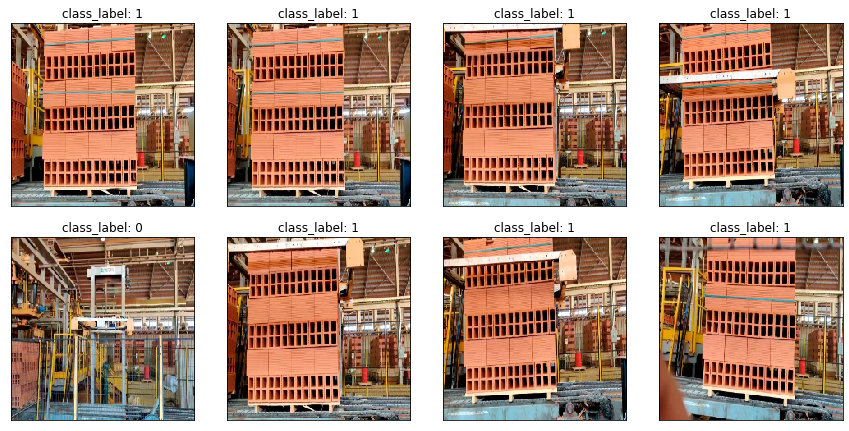

In [13]:
#### PLOT THE DATA

fig = plt.figure(1,figsize=(12,12))
for i in range(8):
  plt.subplot(4,4,i+1)
  plt.tight_layout()
  #x[i] = x[i][:,:,::-1] # converting BGR to RGB
  plt.imshow(x[i][:,:,::-1], interpolation='none')
  plt.title("class_label: {}".format(y[i]))
  plt.xticks([])
  plt.yticks([])
plt

In [14]:
### IMAGE PREPROCESSING

def preprocessing(img,label):
    img = cv2.resize(img,(224,224)) #(config.resize,config.resize)
    img = img/255
    label = np_utils.to_categorical(label, 2)
    return img,label

In [15]:
### CREATE DATA GENERATOR

def data_generator(samples, batch_size=32,shuffle_data=True,resize=224):
    """
    Yields the next training batch.
    Suppose `samples` is an array [[image1_filename,label1], [image2_filename,label2],...].
    """
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        samples = shuffle(samples)

        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]

            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []

            # For each example
            for batch_sample in batch_samples:
                # Load image (X) and label (y)
                img_name = batch_sample[0]
                label = batch_sample[1]
                img =  cv2.imread(os.path.join(root_dir,img_name))
                
                # apply any kind of preprocessing
                img,label = preprocessing(img,label)
                # Add example to arrays
                X_train.append(img)
                y_train.append(label)

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            # The generator-y part: yield the next training batch            
            yield X_train, y_train

In [16]:
### CREATE GENERATOR OBJECT

train_datagen = data_generator(samples,batch_size=8)

x,y = next(train_datagen)
print ('x_shape: ', x.shape)
print ('labels shape: ', y.shape)
print ('labels: ', y)

x_shape:  (8, 224, 224, 3)
labels shape:  (8, 2)
labels:  [[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [17]:
### TRAIN AND TEST DATA PATHS

train_data_path = 'palette_recognition_train.csv'
test_data_path = 'palette_recognition_test.csv'

train_samples = load_samples(train_data_path)
test_samples = load_samples(test_data_path)

num_train_samples = len(train_samples)
num_test_samples = len(test_samples)

print ('number of train samples: ', num_train_samples)
print ('number of test samples: ', num_test_samples)

number of train samples:  3348
number of test samples:  2000


In [18]:
### CREATE GENERATOR 

batch_size = 32 #config.batch_size
train_generator = data_generator(train_samples, batch_size=32)
validation_generator = data_generator(test_samples, batch_size=32)

In [19]:
### CREATE SEQUENTIAL MODEL

input_shape = (224, 224, 3)
print (input_shape)

model = Sequential()

#filters,kernel_size,strides=(1, 1),padding='valid',data_format=None,dilation_rate=(1, 1),activation=None,use_bias=True,
#kernel_initializer='glorot_uniform',bias_initializer='zeros',kernel_regularizer=None,bias_regularizer=None,
#activity_regularizer=None,kernel_constraint=None,bias_constraint=None,

#pool_size=(2, 2), strides=None, padding='valid',data_format=None

model.add(Conv2D(32, (3,3),padding='same',input_shape=input_shape,name='conv2d_1'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_1'))

model.add(Conv2D(32, (3, 3),name='conv2d_2'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_2'))

model.add(Dropout(0.5))

#model.add(Convolution2D(64, 3, 3))
#model.add(Activation('relu'))
#model.add(Convolution2D(64, 3, 3))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2)) #config.num_classes
model.add(Activation('softmax'))

(224, 224, 3)


In [20]:
### MODEL SUMMARY

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 32)      0         
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 110, 110, 32)      0         
_________________________________________________________________
maxpool2d_2 (MaxPooling2D)   (None, 55, 55, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 55, 55, 32)        0

In [21]:
### COMPILE MODEL

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [22]:
### TRAIN MODEL

model.fit(
        train_generator,
        steps_per_epoch=num_train_samples // batch_size,
        epochs=5, #config.num_epochs
        validation_data=validation_generator,
        validation_steps=num_test_samples // batch_size)

model.save_weights('first_try.h5')

Epoch 1/5
104/104 [==============================] - 119s 1s/step - loss: 0.4761 - accuracy: 0.9300 - val_loss: 0.0736 - val_accuracy: 0.9743
Epoch 2/5
104/104 [==============================] - 120s 1s/step - loss: 0.0513 - accuracy: 0.9870 - val_loss: 0.0580 - val_accuracy: 0.9788
Epoch 3/5
104/104 [==============================] - 123s 1s/step - loss: 0.0344 - accuracy: 0.9876 - val_loss: 0.0217 - val_accuracy: 0.9924
Epoch 4/5
104/104 [==============================] - 120s 1s/step - loss: 0.0250 - accuracy: 0.9919 - val_loss: 0.0253 - val_accuracy: 0.9909
Epoch 5/5
104/104 [==============================] - 126s 1s/step - loss: 0.0191 - accuracy: 0.9943 - val_loss: 0.0264 - val_accuracy: 0.9909
